In [1]:
from sompz.functions_sompz import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
from astropy.coordinates import SkyCoord
from astropy import units as u

## Which SOM

In [3]:
# SOM = 'fiducial'
SOM = 'faint'

## Load Balrog data assigned to Deep and Wide cells

In [4]:
if SOM == 'fiducial': 
    balrog_file1= '/global/cscratch1/sd/acampos/sompz_data/v0.50_andresa/deep_balrog_incl_cell_assignment.pkl'
    balrog_file2= '/global/cscratch1/sd/acampos/sompz_data/v0.50_andresa/deep_balrog_incl_cell_assignment2.pkl'

    balrog_data1= pickle.load(open(balrog_file1, 'rb'), encoding='latin1')
    balrog_data2= pickle.load(open(balrog_file2, 'rb'), encoding='latin1')
    balrog_data = pd.concat([balrog_data1, balrog_data2], ignore_index=True)

    print("Length of balrog_data: " + str(len(balrog_data)))
    cells_deep_balrog = balrog_data['cell_deep'].values
    cells_wide_balrog = balrog_data['cell_wide_unsheared'].values
    cell_counts = balrog_data.groupby('cell_wide_unsheared')['cell_wide_unsheared'].count()

elif SOM == 'faint':
    balrog_file= '/global/cscratch1/sd/acampos/sompz_data/v0.50_andresa/deep_balrog.pkl'
    balrog_data= pickle.load(open(balrog_file, 'rb'), encoding='latin1')
    
    print("Length of balrog_data: " + str(len(balrog_data)))
    
    cells_deep_balrog = np.loadtxt('cells_deep_balrog_newSOM_y3.txt', dtype = np.int32)
    cells_wide_balrog = np.loadtxt('cells_wide_balrog_SOMF_230117.txt', dtype = np.int32)
    
    balrog_data['cell_deep'] = cells_deep_balrog
    balrog_data['cell_wide_unsheared'] = cells_wide_balrog
    cell_counts = balrog_data.groupby('cell_wide_unsheared')['cell_wide_unsheared'].count()
    
else:
    print("Which SOM recipe are you using?")

Length of balrog_data: 2417437


## Mag and Color distribution wide cells

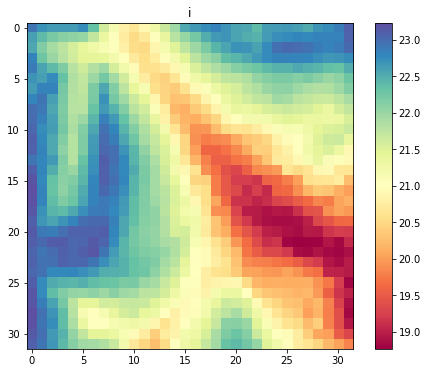

In [5]:
mag_i = balrog_data.groupby('cell_wide_unsheared')['unsheared/flux_i'].mean()

npMag_i = np.array(mag_i)
npMag_i = flux2mag(npMag_i)

plt.figure(figsize=(8,6))
plt.imshow((npMag_i.reshape((32, 32))), cmap='Spectral', interpolation='none')
plt.colorbar()
plt.title('i')
plt.savefig('./mag_i_new_som.png', dpi = 100)

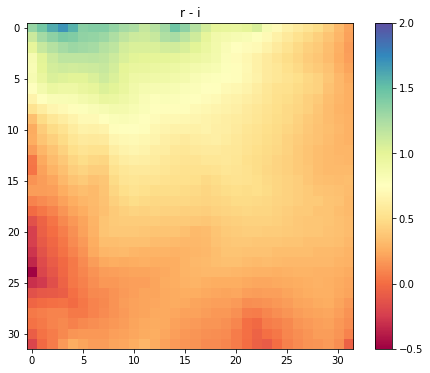

In [6]:
mag_r = balrog_data.groupby('cell_wide_unsheared')['unsheared/flux_r'].mean()
npMag_r = np.array(mag_r)
npMag_r = flux2mag(npMag_r)

color_r = npMag_r - npMag_i

plt.figure(figsize=(8,6))
plt.imshow((color_r.reshape((32, 32))), cmap='Spectral', vmin = -0.5, vmax = 2.0, interpolation='none')
plt.colorbar()
plt.title('r - i')
plt.savefig('./mag_r_new_som.png', dpi = 100)

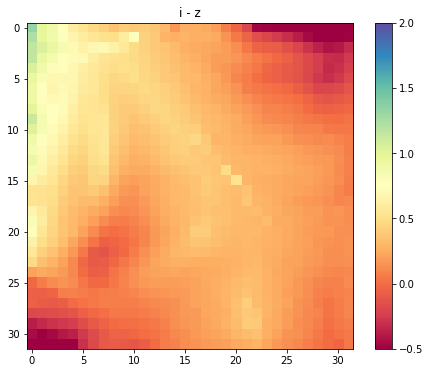

In [7]:
mag_z = balrog_data.groupby('cell_wide_unsheared')['unsheared/flux_z'].mean()
npMag_z = np.array(mag_z)
npMag_z = flux2mag(npMag_z)

color_z =  npMag_i - npMag_z

plt.figure(figsize=(8,6))
plt.imshow((color_z.reshape((32, 32))), cmap='Spectral', vmin = -0.5, vmax = 2.0, interpolation='none')
plt.colorbar()
plt.title('i - z')
plt.savefig('./mag_z_new_som.png', dpi = 100)

## Calculate weights

In [8]:
smooth_response_filename = '/global/u1/d/dgruen/work/sompz/test/full_run_on_data/y3_shape_response_grid_03_31_20.txt'

In [9]:
len_balrog_data = len(balrog_data)

overlap_weight = calculate_weigths(smooth_response_filename, 
                                   balrog_data['unsheared/snr'], 
                                   balrog_data['unsheared/size_ratio'], 
                                   balrog_data["injection_counts"], 
                                   balrog_data['unsheared/weight'], 
                                   len_balrog_data)

In [10]:
balrog_data['overlap_weight'] = overlap_weight

## Calculate pcchat

In [11]:
deep_som_size = 64*64 
wide_som_size = 32*32

pcchat_num = np.zeros((deep_som_size, wide_som_size))

np.add.at(pcchat_num, [cells_deep_balrog, cells_wide_balrog], overlap_weight)  # sum(w)[c, chat]
pcchat_denom = pcchat_num.sum(axis=0)
pcchat = pcchat_num / pcchat_denom[None]

# any nonfinite in pcchat are to be treated as 0 probability
pcchat = np.where(np.isfinite(pcchat), pcchat, 0)
pcchat

/global/homes/a/acampos/.conda/envs/mySOM/lib/python3.9/site-packages/pandas/core/arraylike.py:364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0012178 , 0.0003258 , 0.00041286, ..., 0.        , 0.        ,
        0.        ],
       [0.00445255, 0.00034875, 0.00118747, ..., 0.        , 0.        ,
        0.        ],
       [0.00075586, 0.        , 0.00030299, ..., 0.        , 0.        ,
        0.        ]])

In [12]:
# plt.figure(figsize=(40,80))
# plt.imshow(pcchat,cmap='Spectral', vmin = 0.0, vmax = 0.01,interpolation='none')
# plt.title('Old SOM Transfer')
# plt.savefig('transfer_matrix_old.png', dpi=100)
# plt.colorbar()

In [13]:
cosmos_z = pd.read_hdf('/global/cscratch1/sd/jmyles/COSMOS2015/sompz_cosmos.h5')

cosmos = balrog_data[balrog_data['FIELD']=='COSMOS'].copy()

c = SkyCoord(ra=cosmos_z['ALPHA_J2000'].values *u.degree, dec=cosmos_z['DELTA_J2000'].values*u.degree)
catalog = SkyCoord(ra=cosmos['RA'].values*u.degree, dec=cosmos['DEC'].values*u.degree)

matchlim = 0.75
idx, d2d, d3d = catalog.match_to_catalog_sky(c)
is_match = d2d < matchlim * u.arcsec

cosmos['Z'] = -1
cosmos.loc[is_match, 'Z'] = cosmos_z.iloc[idx[is_match], cosmos_z.columns.get_loc('PHOTOZ')].values

cosmos['Z2'] = -1
cosmos.loc[is_match, 'Z2'] = cosmos_z.iloc[idx[is_match], cosmos_z.columns.get_loc('ZP_2')].values

cosmos['2peak'] = -1
cosmos.loc[is_match, '2peak'] = cosmos_z.iloc[idx[is_match], cosmos_z.columns.get_loc('SECOND_PEAK')].values

zpdfcols = ["Z{:.2f}".format(s).replace(".","_") for s in np.arange(0,6.01,0.01)]
zpdfcols_indices = [cosmos_z.columns.get_loc(_) for _ in zpdfcols]
cosmos[zpdfcols] = pd.DataFrame(-1 * np.ones((len(cosmos), len(zpdfcols))), columns=zpdfcols, index=cosmos.index)
cosmos.loc[is_match, zpdfcols] = cosmos_z.iloc[idx[is_match], zpdfcols_indices].values

cosmos.loc[is_match, 'LAIGLE_ID'] = cosmos_z.iloc[idx[is_match], cosmos_z.columns.get_loc('ID')].values
ids, counts = np.unique(cosmos.loc[is_match, 'LAIGLE_ID'], return_counts=True)

print('n duplicated Laigle', len(counts[counts > 1]))

print("all cosmos deep: ", len(cosmos['BDF_MAG_DERED_CALIB_R']))
#OLD: print("matched cosmos deep: ", len(cosmos['BDF_MAG_DERED_R'].iloc[idx[is_match]]))
print("matched cosmos deep: ", len(cosmos['BDF_MAG_DERED_CALIB_R'].loc[is_match]))
print("unmatched cosmos deep: ", len(cosmos['BDF_MAG_DERED_CALIB_R'][cosmos['Z'] == -1]))
nomatch=cosmos[cosmos['Z'] == -1]

cosmos = cosmos[cosmos['Z'] != -1].copy()

/global/homes/a/acampos/.conda/envs/mySOM/lib/python3.9/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]
/global/homes/a/acampos/.conda/envs/mySOM/lib/python3.9/site-packages/pandas/core/indexing.py:1678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = empty_value


n duplicated Laigle 39399
all cosmos deep:  521851
matched cosmos deep:  451766
unmatched cosmos deep:  70085


In [14]:
spec_data = cosmos.copy()

## Bin assignment

In [15]:
ncells_wide = wide_som_size
ncells_deep = deep_som_size

In [16]:
inj_counts = balrog_data['injection_counts']
inj_ids = balrog_data['true_id']

In [17]:
y3_bins =  [0.0, 0.358, 0.631, 0.872, 2.0] #[0.0, 0.357, 0.63, 0.875, 2.0]

# assign gals in redshift sample to bins
spec_data['tomo_bin_y3'] = pd.cut(spec_data['Z'], y3_bins, labels=[0,1,2,3])
nwidecells = wide_som_size
ncells_with_spec_data = len(np.unique(spec_data['cell_wide_unsheared'].values))

cell_bin_assignment_y3 = np.ones(nwidecells, dtype=int) * -1
cells_with_spec_data = np.unique(spec_data['cell_wide_unsheared'].values)

groupby_obj_value_counts = spec_data.groupby('cell_wide_unsheared')['tomo_bin_y3'].value_counts()

for c in cells_with_spec_data:
    bin_assignment = groupby_obj_value_counts.loc[c].index[0]
    cell_bin_assignment_y3[c] = bin_assignment

# reformat bins into dict
tomo_bins_wide = {}
for i in range(4):
        tomo_bins_wide[i] = np.where(cell_bin_assignment_y3 == i)[0]

## Load Wide Galaxies

In [18]:
# Rwide catalog
wide_field_file = '/global/cscratch1/sd/acampos/sompz_data/Y3_mastercat_03_31_20.h5'
f = h5py.File(wide_field_file,'r') # this is the master catalog
widebands = 'irz'

# Cell Assignment

if SOM == 'fiducial': 

    # file with the SOM assignment for the wide galaxies
    sompzh5_file = '/global/cscratch1/sd/acampos/sompz_data/v0.50_andresa/sompz_v0.50_20_07_2021.h5'
    sompzh5 = h5py.File(sompzh5_file, mode='r')
    nrows = sompzh5['catalog/sompz/unsheared/coadd_object_id'].shape[0]
    
    df_dict_cell = {'cell_wide_unsheared' : np.array(sompzh5['catalog/sompz/unsheared/cell_wide'])}
    df_dict = {}
    df_dict.update(df_dict_cell)
    sompzh5_data = pd.DataFrame(df_dict)
    select_metacal  = f['index']['select']
    sompzh5_pass = sompzh5_data.iloc[select_metacal].copy()
    
elif SOM == 'faint':    
    
    cells_wide       = np.loadtxt('./cells_wide_unsheared_newSOM_y3.txt', dtype = np.int32) 
    cells_sheared_1m = np.loadtxt('./cells_wide_sheared_1m_newSOM_y3.txt', dtype = np.int32)
    cells_sheared_1p = np.loadtxt('./cells_wide_sheared_1p_newSOM_y3.txt', dtype = np.int32)
    cells_sheared_2m = np.loadtxt('./cells_wide_sheared_2m_newSOM_y3.txt', dtype = np.int32)
    cells_sheared_2p = np.loadtxt('./cells_wide_sheared_2p_newSOM_y3.txt', dtype = np.int32)

    df_dict_cell = {'cell_wide_unsheared' : np.array(cells_wide),
                    'cell_wide_sheared_1m' : np.array(cells_sheared_1m),
                    'cell_wide_sheared_1p' : np.array(cells_sheared_1p),
                    'cell_wide_sheared_2m' : np.array(cells_sheared_2m),
                    'cell_wide_sheared_2p' : np.array(cells_sheared_2p)}
    df_dict = {}
    df_dict.update(df_dict_cell)
    sompzh5_data = pd.DataFrame(df_dict)
    select_metacal  = f['index']['select']
    sompzh5_pass = sompzh5_data.copy()   
    
    
# Wide Data
sompzh5_pass['coadd_object_id'] = np.array(f['catalog/metacal/unsheared/coadd_object_id'][:])[select_metacal] # make numpy array before applying mask
# sompzh5_pass['unsheared/flux_i'] = np.array(f['catalog/metacal/unsheared/flux_i'][:])[select_metacal]
# sompzh5_pass['unsheared/flux_r'] = np.array(f['catalog/metacal/unsheared/flux_r'][:])[select_metacal]
# sompzh5_pass['unsheared/flux_z'] = np.array(f['catalog/metacal/unsheared/flux_z'][:])[select_metacal]
sompzh5_pass['unsheared/T'] = np.array(f['catalog/metacal/unsheared/T'][:])[select_metacal]
sompzh5_pass['unsheared/snr'] = np.array(f['catalog/metacal/unsheared/snr'][:])[select_metacal]

#ADD WEIGHTS
wide_overlap_weight = np.ones(len(select_metacal))
wide_overlap_weight *= np.array(f['catalog/metacal/unsheared/R11'][:])[select_metacal]+np.array(f['catalog/metacal/unsheared/R22'][:])[select_metacal]
wide_overlap_weight *= np.array(f['catalog/metacal/unsheared/weight'][:])[select_metacal]

sompzh5_pass['overlap_weight'] = wide_overlap_weight

f.close()
print("done")

done


In [19]:
sompzh5_pass

,cell_wide_unsheared,cells_wide_sheared_1m,cells_wide_sheared_1p,cells_wide_sheared_2m,cells_wide_sheared_2p,coadd_object_id,unsheared/T,unsheared/snr,overlap_weight
0,547,547,547,547,547,333399043,0.398437,27.344698,43.840452
1,982,982,982,982,982,333399053,0.688069,25.718347,78.215476
2,789,789,789,789,789,333399042,1.097025,144.845874,64.953176
3,26,26,26,26,26,333399121,0.294478,11.964976,14.914593
4,202,202,203,202,202,333399011,0.260059,38.374291,51.356723
...,...,...,...,...,...,...,...,...,...
100208939,16,16,16,16,16,178659752,0.154831,13.364411,26.071866
100208940,972,972,972,972,972,178659430,1.566490,34.240978,110.480841
100208941,411,411,411,411,411,178659954,0.325116,45.778681,70.872368
100208942,557,557,558,557,558,178659841,0.286899,52.567688,71.421045


## Wide Galaxies Cell Ocupation and Binning

In [20]:
cell_occupation_info = sompzh5_pass.groupby('cell_wide_unsheared')['cell_wide_unsheared'].count()
pickle.dump(cell_occupation_info, open('cell_occupation_info_SOMF_230117.pkl', 'wb'))

In [21]:
n_bins = 4
bin_occupation_info = {'bin' + str(i) : np.sum(cell_occupation_info.loc[tomo_bins_wide[i]].values) for i in range(n_bins)}

In [22]:
bin_occupation_info

{'bin0': 23580877, 'bin1': 27236473, 'bin2': 24773059, 'bin3': 24618535}

In [23]:
if -1 in tomo_bins_wide.keys():
    print('WARNING! There are {0} galaxies of the wide sample in the no redshift bin. This is a really bad sign.'.format(len(tomo_bins_wide[-1])))
    tomo_bins_wide = {k: tomo_bins_wide[k] for k in range(n_bins)}

if len(tomo_bins_wide)!=n_bins: # this is a bad sign
    print('WARNING! You have a different number of bins than you thought you had. This could cause some mess.')


# convert to format where tomo_bins_wide[i] is a 2D array, first column cell_id, second column an arbitrary weight

for k in tomo_bins_wide:
	if tomo_bins_wide[k].ndim==1:
		tomo_bins_wide[k] = np.column_stack((tomo_bins_wide[k],np.ones(len(tomo_bins_wide[k]))))
	renorm = 1./np.average(tomo_bins_wide[k][:,1])
	tomo_bins_wide[k][:,1] *= renorm # renormalize so the mean weight is 1; important for bin conditioning

## Functions

In [24]:
deep_map_shape = (64*64, )

In [25]:
def histogram(data, key, cells, cell_weights, pcchat, overlap_weighted_pzc,deep_som_size = 64*64, bins=None, individual_chat=False, interpolate_kwargs={}):
    """Return histogram from values that live in specified wide cells by querying deep cells that contribute

    Parameters
    ----------
    key                  : Parameter(s) to extract from dataframe
    cells                : A list of wide cells to return sample from, or a single int.
    cell_weights         : How much we weight each wide cell. This is the array p(chat | sample)
    overlap_weighted_pzc : Weight contribution of galaxies within c by overlap_weight, if True. Weighting for p(c|chat) is done using stored transfer matrix.
    bins                 : Bins we histogram the values into
    individual_chat      : If True, compute p(z|chat) for each individual cell in cells. If False, compute a single p(z|{chat}) for all cells.
    interpolate_kwargs   : arguments to pass in for performing interpolation between cells for redshift hists using a 2d gaussian of sigma scale_length out to max_length cells away. The two kwargs are: 'scale_length' and 'max_length'

    Returns
    -------
    hist : a histogram of the values from self.data[key]

    Notes
    -----
    This method tries to marginalize wide assignments into what deep assignments it has

    """
    # get sample, p(z|c)
    all_cells = np.arange(deep_som_size)
    hists_deep = get_deep_histograms(data, key=key, cells=all_cells, overlap_weighted_pzc=overlap_weighted_pzc, bins=bins, interpolate_kwargs=interpolate_kwargs)
    if individual_chat: # then compute p(z|chat) for each individual cell in cells and return histograms
        hists = []
        for i, (cell, cell_weight) in enumerate(zip(cells, cell_weights)):
            # p(c|chat,s)p(chat|s) = p(c,chat|s)
            possible_weights = pcchat[:, [cell]] * np.array([cell_weight])[None]  # (n_deep_cells, 1)
            # sum_chat p(c,chat|s) = p(c|s)
            weights = np.sum(possible_weights, axis=-1)
            conds = (weights != 0) & np.all(np.isfinite(hists_deep), axis=1)
            # sum_c p(z|c) p(c|s) = p(z|s)
            hist = np.sum((hists_deep[conds] * weights[conds, None]), axis=0)

            dx = np.diff(bins)
            normalization = np.sum(dx * hist)
            if normalization != 0:
                hist = hist / normalization
            hists.append(hist)
        return hists
    else: # compute p(z|{chat}) and return histogram
        # p(c|chat,s)p(chat|s) = p(c,chat|s)
        possible_weights = pcchat[:, cells] * cell_weights[None]  # (n_deep_cells, n_cells)
        # sum_chat p(c,chat|s) = p(c|s)
        weights = np.sum(possible_weights, axis=-1)
        conds = (weights != 0) & np.all(np.isfinite(hists_deep), axis=1)
        # sum_c p(z|c) p(c|s) = p(z|s)
        hist = np.sum((hists_deep[conds] * weights[conds, None]), axis=0)

        dx = np.diff(bins)
        normalization = np.sum(dx * hist)
        if normalization != 0:
            hist = hist / normalization
        return hist

def redshift_distributions_wide(data, overlap_weighted_pchat, overlap_weighted_pzc, bins, pcchat, tomo_bins={}, key='Z', force_assignment=True, interpolate_kwargs={}, **kwargs):
    """Returns redshift distribution for sample

    Parameters
    ----------
    data :      Data sample of interest with wide data
    overlap_weighted_pchat  : If True, use overlap weights for p(chat)
    overlap_weighted_pzc : If True, use overlap weights for p(z|c)
                Note that whether p(c|chat) is overlap weighted depends on how you built pcchat earlier.
    bins :      bin edges for redshift distributions data[key]
    tomo_bins : Which cells belong to which tomographic bins. First column is
                cell id, second column is an additional reweighting of galaxies in cell.
                If nothing is passed in, then we by default just use all cells
    key :       redshift key
    force_assignment : Calculate cell assignments. If False, then will use whatever value is in the cell_key field of data. Default: True
    interpolate_kwargs : arguments to pass in for performing interpolation
    between cells for redshift hists using a 2d gaussian of sigma
    scale_length out to max_length cells away. The two kwargs are:
    'scale_length' and 'max_length'

    Returns
    -------
    hists : Either a single array (if no tomo_bins) or multiple arrays

    """
    if len(tomo_bins) == 0:
        cells, cell_weights = get_cell_weights_wide(data, overlap_weighted_pchat=overlap_weighted_pchat, force_assignment=force_assignment, **kwargs)
        if cells.size == 0:
            hist = np.zeros(len(bins) - 1)
        else:
            hist = histogram(data, key=key, cells=cells, cell_weights=cell_weights, overlap_weighted_pzc=overlap_weighted_pzc, bins=bins, interpolate_kwargs=interpolate_kwargs)
        return hist
    else:
        cells, cell_weights = get_cell_weights_wide(data, overlap_weighted_pchat, force_assignment=force_assignment, **kwargs)
        cellsort = np.argsort(cells)
        cells = cells[cellsort]
        cell_weights = cell_weights[cellsort]

        # break up hists into the different bins
        hists = []
        for tomo_key in tomo_bins:
            cells_use     = tomo_bins[tomo_key][:,0]
            cells_binweights = tomo_bins[tomo_key][:,1]
            cells_conds   = np.searchsorted(cells, cells_use,side='left')
            if len(cells_conds) == 0:
                hist = np.zeros(len(bins) - 1)
            else:
                hist = histogram(data, key=key, cells=cells[cells_conds], cell_weights=cell_weights[cells_conds]*cells_binweights, pcchat = pcchat, overlap_weighted_pzc=overlap_weighted_pzc, bins=bins, interpolate_kwargs=interpolate_kwargs)
            hists.append(hist)
        hists = np.array(hists)
        return hists


def get_deep_histograms(data, key, cells, overlap_weighted_pzc, bins,cosmos = cosmos, overlap_key= 'overlap_weight',deep_som_size = 64*64, deep_map_shape = (64*64, ), interpolate_kwargs={}):
    """Return individual deep histograms for each cell. Can interpolate for empty cells.

    Parameters
    ----------
    key   : Parameter to extract from dataframe
    cells : A list of deep cells to return sample from, or a single int.
    overlap_weighted_pzc : Use overlap_weights in p(z|c) histogram if True. Also required if you want to bin conditionalize
    overlap_key : column name for the overlap weights in the dataframe, default to 'overlap_weight'
    bins  : Bins we histogram the values into
    interpolate_kwargs : arguments to pass in for performing interpolation
    between cells for redshift hists using a 2d gaussian of sigma
    scale_length out to max_length cells away. The two kwargs are:
    'scale_length' and 'max_length'
    data : subset of redshift information to conditionalize on. i.e. for use with computing p(z|c,is_in_data)
    Returns
    -------
    hists : a histogram of the values from self.data[key] for each deep cell
    """

    if len(interpolate_kwargs) > 0:
        cells_keep = cells
        cells = np.arange(deep_som_size)
    else:
        cells_keep = cells

    hists = []
    missing_cells = []
    populated_cells = []
    for ci, c in enumerate(cells):
        try:
            df = cosmos.groupby('cell_deep').get_group(c)
            if type(key) is str:
                z = df[key].values
                if(overlap_weighted_pzc==True):
                    #print("WARNING: You are using a deprecated point estimate Z. No overlap weighting enabled. You're on your own now.")#suppress
                    weights = df[overlap_key].values
                else:
                    weights = np.ones(len(z))
                hist = np.histogram(z, bins, weights=weights, density=True)[0] #make weighted histogram by overlap weights
                populated_cells.append([ci, c])
            elif type(key) is list:
                # use full p(z)
                assert(bins is not None)
                hist = histogram_from_fullpz(df, key, overlap_weighted=overlap_weighted_pzc, bin_edges=bins)
            hists.append(hist)
        except KeyError as e:
            missing_cells.append([ci, c])
            hists.append(np.zeros(len(bins) - 1))
    hists = np.array(hists)

    if len(interpolate_kwargs) > 0:
        # print('Interpolating {0} missing histograms'.format(len(missing_cells)))
        missing_cells = np.array(missing_cells)
        populated_cells = np.array(populated_cells)
        hist_conds = np.isin(cells, populated_cells[:, 1]) & np.all(np.isfinite(hists), axis=1)
        for ci, c in missing_cells:
            if c not in cells_keep:
                # don't worry about interpolating cells we won't use anyways
                continue

            central_index = np.zeros(len(deep_map_shape), dtype=int)
            # unravel_index(c, deep_map_shape, central_index)  # fills central_index
            cND = np.zeros(len(deep_map_shape), dtype=int)
            weight_map = np.zeros(deep_som_size)
            # gaussian_rbf(weight_map, central_index, cND, deep_map_shape, **interpolate_kwargs)  # fills weight_map
            hists[ci] =  np.sum(hists[hist_conds] * (weight_map[hist_conds] / weight_map[hist_conds].sum())[:, None], axis=0)

        # purge hists back to the ones we care about
        hists = hists[cells_keep]

    return hists

## DataFrames

In [26]:
sompzh5_pass

,cell_wide_unsheared,cells_wide_sheared_1m,cells_wide_sheared_1p,cells_wide_sheared_2m,cells_wide_sheared_2p,coadd_object_id,unsheared/T,unsheared/snr,overlap_weight
0,547,547,547,547,547,333399043,0.398437,27.344698,43.840452
1,982,982,982,982,982,333399053,0.688069,25.718347,78.215476
2,789,789,789,789,789,333399042,1.097025,144.845874,64.953176
3,26,26,26,26,26,333399121,0.294478,11.964976,14.914593
4,202,202,203,202,202,333399011,0.260059,38.374291,51.356723
...,...,...,...,...,...,...,...,...,...
100208939,16,16,16,16,16,178659752,0.154831,13.364411,26.071866
100208940,972,972,972,972,972,178659430,1.566490,34.240978,110.480841
100208941,411,411,411,411,411,178659954,0.325116,45.778681,70.872368
100208942,557,557,558,557,558,178659841,0.286899,52.567688,71.421045


In [27]:
balrog_data

,BDF_FLUX_DERED_CALIB_G,BDF_FLUX_DERED_CALIB_I,BDF_FLUX_DERED_CALIB_R,BDF_FLUX_DERED_CALIB_U,BDF_FLUX_DERED_CALIB_Z,BDF_FLUX_ERR_DERED_CALIB_G,BDF_FLUX_ERR_DERED_CALIB_I,BDF_FLUX_ERR_DERED_CALIB_R,BDF_FLUX_ERR_DERED_CALIB_U,BDF_FLUX_ERR_DERED_CALIB_Z,...,sheared_2m/flux_ivar_z,sheared_2p/flux_ivar_i,sheared_2p/flux_ivar_r,sheared_2p/flux_ivar_z,unsheared/flux_ivar_i,unsheared/flux_ivar_r,unsheared/flux_ivar_z,cell_deep,cell_wide_unsheared,overlap_weight
0,1212.135106,5087.703775,3176.874219,811.731709,6493.260744,9.299783,26.633027,19.551319,12.300394,37.720830,...,0.000033,0.000078,0.000310,0.000034,0.000062,0.000246,0.000027,2207,373,0.676145
1,1212.135106,5087.703775,3176.874219,811.731709,6493.260744,9.299783,26.633027,19.551319,12.300394,37.720830,...,0.000065,0.000172,0.000613,0.000063,0.000180,0.000643,0.000066,2207,341,0.876120
2,1212.135106,5087.703775,3176.874219,811.731709,6493.260744,9.299783,26.633027,19.551319,12.300394,37.720830,...,0.000010,0.000035,0.000095,0.000012,0.000038,0.000103,0.000013,2207,496,0.606649
3,1212.135106,5087.703775,3176.874219,811.731709,6493.260744,9.299783,26.633027,19.551319,12.300394,37.720830,...,0.000058,0.000108,0.000350,0.000041,0.000121,0.000395,0.000046,2207,593,0.771923
4,1212.135106,5087.703775,3176.874219,811.731709,6493.260744,9.299783,26.633027,19.551319,12.300394,37.720830,...,0.000083,0.000229,0.000705,0.000087,0.000223,0.000686,0.000084,2207,438,0.806256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2417432,-1003.650453,765.977697,467.001327,130.372828,441.365717,79623.923041,106.568883,260.633809,51.937477,70.353233,...,0.000064,0.000188,0.000411,0.000065,0.000206,0.000451,0.000072,2498,677,0.278572
2417433,-1003.650453,765.977697,467.001327,130.372828,441.365717,79623.923041,106.568883,260.633809,51.937477,70.353233,...,0.000139,0.000381,0.001295,0.000134,0.000383,0.001307,0.000135,2498,23,0.154803
2417434,-1003.650453,765.977697,467.001327,130.372828,441.365717,79623.923041,106.568883,260.633809,51.937477,70.353233,...,0.000212,0.000503,0.001290,0.000233,0.000483,0.001236,0.000222,2498,26,0.154803
2417435,-1003.650453,765.977697,467.001327,130.372828,441.365717,79623.923041,106.568883,260.633809,51.937477,70.353233,...,0.000084,0.000130,0.000359,0.000087,0.000125,0.000346,0.000084,2498,28,0.186872


In [28]:
zbins_max = 6.00
zbins_dz  = 0.01
# settings for output histogram - note that zbins_max needs to agree with Laigle currently

zmax_pileup = 3.0
zmax_weight = 1.0
# all z-bins above zmax_pileup will be piled into this last bin
# Can up or downweight the last bin

zp_catalog = 30


zbins = np.arange(-zbins_dz/2.,zbins_max+zbins_dz,zbins_dz) # need to match Laigle binning if in 'usepz' mode
zmean=(zbins[1:] + zbins[:-1])/2
fullpz = ["Z{:.2f}".format(s).replace(".","_") for s in np.arange(0,6.01,0.01)] # stays hardcoded while we use Laigle catalog as only truth
pointz = 'Z'

key = fullpz
keylabel = 'fullpz'
keylabel = 'modal_even'

In [29]:
# (5) write h5 file including binning information

# OLD, i.e. not bin conditioned, n(z)
hists_wide = redshift_distributions_wide(sompzh5_pass, 
                                         True, 
                                         True, 
                                         zbins,
                                         pcchat = pcchat,
                                         tomo_bins=tomo_bins_wide, 
                                         force_assignment=False,
                                         cell_key='cell_wide_unsheared', 
                                         key=key)
np.save('Y3_hists_wide_NOT_BIN_CONDITIONALIZED_{}.npy'.format(keylabel), hists_wide)

# cm.save_des_nz(hists_wide, zbins, n_bins, data_dir, run_name, keylabel)
plot_nz(hists_wide, zbins, 'Y3_nz_newbinning_onwide_NOT_BIN_CONDITIONALIZED_{}.png'.format(keylabel))

#printlog("spec_data length: " + str(len(spec_data)))
# printlog("stored spec_data length: " + str(len(cm.data)))

## Bin Conditionalization

In [30]:
def nz_bin_conditioned(wfdata, cosmos, overlap_weighted_pchat, overlap_weighted_pzc, tomo_cells, zbins, cell_wide_key='cell_wide', zkey='Z'):
    """ Function to obtain p(z|bin,s): the redshift distribution of a tomographic bin
    including the tomographic selection effect in p(z|chat).

    Implementation note:
    This is going to sneak the bin conditionalization into the overlap weights, and then divide them back out.
    This is a simple way of achieving to not completely lose cells c that contribute to p(c|chat) but don't have a z in b.
    Not the cleanest code written by a human.

        Parameters
        ----------
        wfdata : Wide field data
        overlap_weighted_pchat : If True, weight chat by the sum of overlap weights, not number of galaxies, in wide field data.
        tomo_cells : Which cells belong to this tomographic bin. First column is
                     cell id, second column is an additional reweighting of galaxies in that cell.
        zbins : redshift bin edges.
        cell_wide_key : key for wide SOM cell id information in spec_data.
        cell_deep_key : key for wide SOM cell id information in spec_data.
        #cells : A list of deep cells to return sample from, or a single int.
        #cell_weights : How much we weight each wide cell. This is the array p(c | sample)
    """
    print('full redshift sample:', len(cosmos))
    #print('cell_wide_key: ', cell_wide_key)
    #print('self.data[cell_wide_key].shape', self.data[cell_wide_key].shape)
    #print('tomo_cells', tomo_cells)
    bl=len(cosmos[cosmos['cell_wide_unsheared'].isin(tomo_cells[:,0])])

    print('subset of reshift sample in bin:', bl)

    f=1.e9 # how much more we weight the redshift of a galaxy that's in the right bin

    stored_overlap_weight = cosmos['overlap_weight'].copy() # save for later

    if(overlap_weighted_pzc == False): # we need to use it, but you don't want to
        cosmos['overlap_weight'] = np.ones(len(cosmos))

    cosmos.loc[cosmos['cell_wide_unsheared'].isin(tomo_cells[:,0]),'overlap_weight'] *= f

    nz = redshift_distributions_wide(data=wfdata, overlap_weighted_pchat=overlap_weighted_pchat, overlap_weighted_pzc=True,
                                     bins=zbins, pcchat = pcchat, tomo_bins={"mybin" : tomo_cells}, key=zkey, force_assignment=False, cell_key=cell_wide_key)

    cosmos['overlap_weight'] = stored_overlap_weight.copy() # open jar

    return nz[0]

In [31]:
####################
# BEGIN bin conditionalized n(z)

data_dir = './'

cells, cell_weights_wide = get_cell_weights_wide(sompzh5_pass, overlap_weighted_pchat=True, force_assignment=False, cell_key='cell_wide_unsheared')

np.save(data_dir + 'Y3_pchat_{}.npy'.format(keylabel), cell_weights_wide)
hists_wide_bin_cond = np.array([nz_bin_conditioned(sompzh5_pass, cosmos, True, overlap_weighted_pzc=True, tomo_cells=tomo_bins_wide[i], 
                                                      zbins=zbins, cell_wide_key='cell_wide_unsheared', zkey=key) for i in range(n_bins)])

np.save(data_dir + 'Y3_hists_wide_bin_conditionalized_{}.npy'.format(keylabel), hists_wide_bin_cond)
# cm.save_des_nz(hists_wide_bin_cond, zbins, n_bins, data_dir, run_name, keylabel+'_bincond')
plot_nz(hists_wide_bin_cond, zbins, data_dir + 'Y3_nz_newbinning_onwide_bin_cond_{}.png'.format(keylabel))
plot_nz_overlap([hists_wide_bin_cond], [keylabel], data_dir)
#END bin conditionalized n(z)

full redshift sample: 451766
subset of reshift sample in bin: 104053
full redshift sample: 451766
subset of reshift sample in bin: 122062
full redshift sample: 451766
subset of reshift sample in bin: 115420
full redshift sample: 451766
subset of reshift sample in bin: 110231


No handles with labels found to put in legend.


## Pile up

Dz, new-end-z,weight:  0.01 3.0 1.0
Dz, new-end-z,weight:  0.01 3.0 1.0
       norm      mean     sigma              label  tomo
0  0.999563  0.326749  0.281091               true     0
1  0.999456  0.324587  0.283558  using p(z|c,bhat)     0
2  0.999348  0.510729  0.296778               true     1
3  0.999368  0.507119  0.295606  using p(z|c,bhat)     1
4  0.999616  0.730637  0.217053               true     2
5  0.999650  0.733510  0.204272  using p(z|c,bhat)     2
6  0.999524  0.918894  0.306935               true     3
7  0.999466  0.926190  0.302790  using p(z|c,bhat)     3
   delta <z>  delta sigma(z)
0   0.002163       -0.002467
1   0.003610        0.001172
2  -0.002874        0.012781
3  -0.007295        0.004145
mkdir -p ./
write ./Y3_y3_redshift_distributions_test_modal_even_Y3_bincond_pileup3.fits


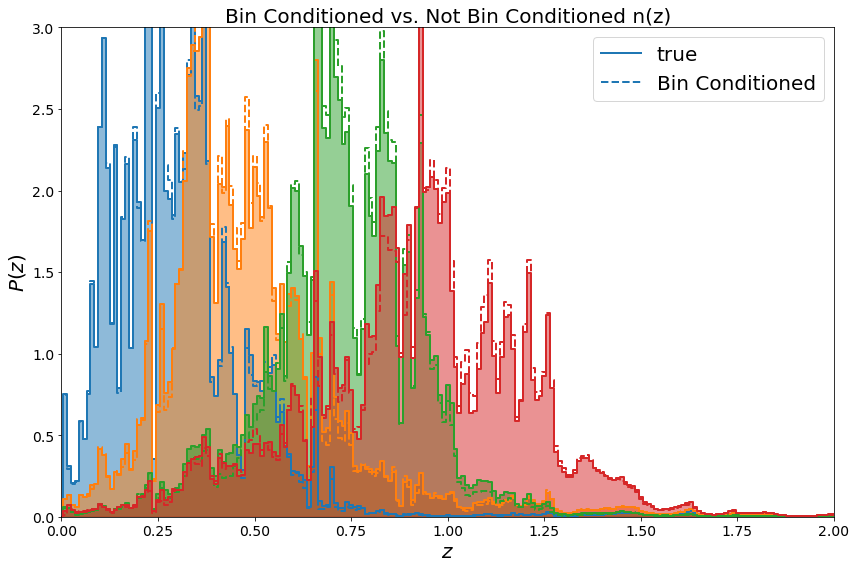

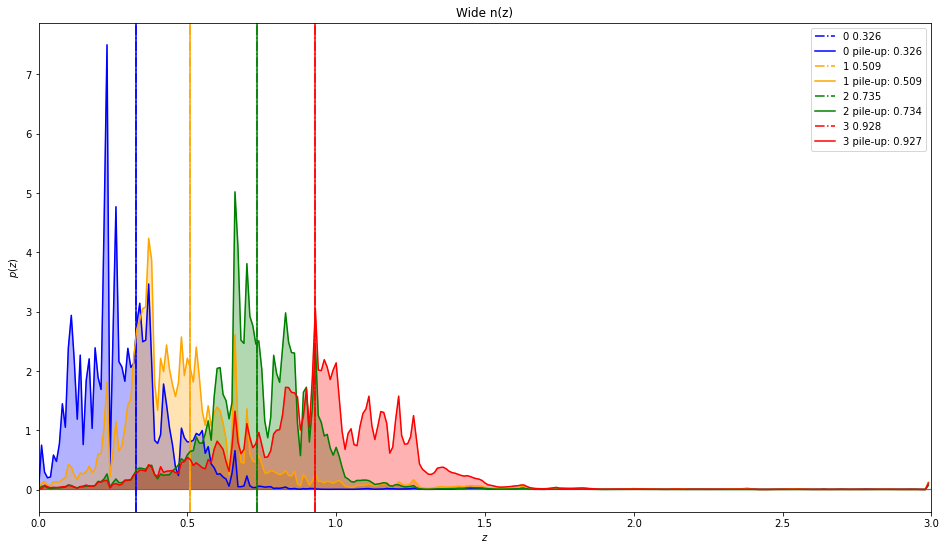

In [34]:
####################
# Pile up very high z
run_name = 'test'

zbins_piled,zmean_piled, hists_wide_piled=pileup(hists_wide,zbins,zmean,zmax_pileup,zbins_dz,zmax_weight,n_bins)
zbins_piled,zmean_piled, hists_wide_bin_cond_piled=pileup(hists_wide_bin_cond,zbins,zmean,zmax_pileup,zbins_dz,zmax_weight,n_bins)

#plot comparing bin_cond with pileup
results, deltas = redshift_histograms_stats(hists_wide_piled, hists_wide_bin_cond_piled, zbins_piled, 'using p(z|c,bhat)')
fig_wide = plot_redshift_histograms(hists_wide_piled, hists_wide_bin_cond_piled, zbins_piled, 'Bin Conditioned vs. Not Bin Conditioned n(z)', 'Bin Conditioned', max_pz = 3)
fig_wide.savefig(data_dir + 'Y3_pzc_vs_pzcbhat_wide_faint.png', dpi=300)
print(results)
print(deltas)

#plot comparing pileup effect
means_bc, sigmas_bc = get_mean_sigma(zmean, hists_wide_bin_cond)
means_bc_piled, sigmas_bc_piled = get_mean_sigma(zmean_piled, hists_wide_bin_cond_piled)
plt.figure(figsize=(16.,9.))
colors=['blue','orange','green','red']
for i in range(len(hists_wide)):
    plt.fill_between(zmean, hists_wide_bin_cond[i], color= colors[i],alpha=0.3) #,label="fiducial")
    plt.axvline(means_bc[i], linestyle='-.', color= colors[i],label=str(i)+' %.3f'%(means_bc[i]))
    plt.plot(zmean_piled, hists_wide_bin_cond_piled[i], color= colors[i])#,label="bin conditional")
    plt.axvline(means_bc_piled[i], linestyle='-', color= colors[i],label=str(i)+' pile-up: %.3f'%(means_bc_piled[i]) )
plt.xlabel(r'$z$')
plt.ylabel(r'$p(z)$')
plt.xlim(0,3)
plt.legend()
plt.title('Wide n(z)')
plt.savefig(data_dir + 'Y3_nz_newbinning_onwide_bin_cond_pileup3_faint.png')

#save
deltas.to_pickle(data_dir + 'Y3_deltas_pzc_pzcbhat.pkl')
results.to_pickle(data_dir + 'Y3_results_pzc_pzcbhat.pkl')
np.save(data_dir + 'Y3_hists_wide_bin_conditionalized_pileup3_{}.npy'.format(keylabel), hists_wide_bin_cond_piled)
save_des_nz(hists_wide_bin_cond_piled, zbins_piled, n_bins, data_dir, run_name, keylabel+'_Y3_bincond_pileup3')

#zbins=zbins_piled
hists_wide = hists_wide_bin_cond_piled # this is what is used moving forward.
#END pile up

## Smooth

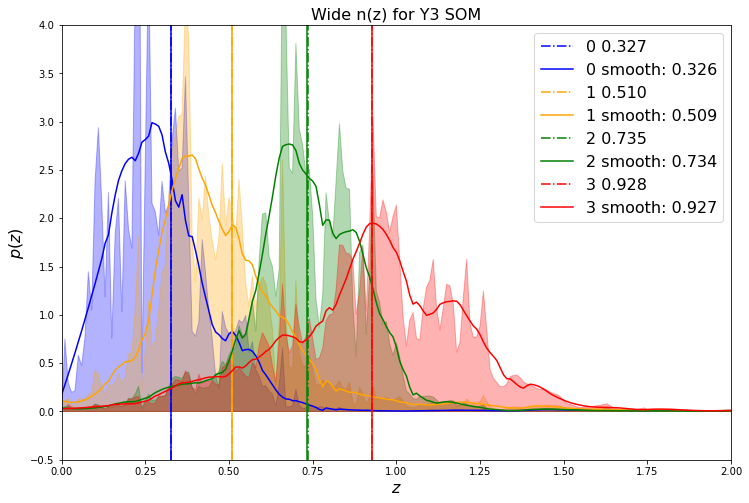

In [35]:
####################
# Smooth

# templatef='/global/cscratch1/sd/aamon/DVs/template.fits'
templatef='/global/cscratch1/sd/acampos/cosmosis/cosmosis-des-library/y3-3x2pt/data/des-y3/sim_data_vectors/sim_3x2pt_TATT_sample3.fits'


filen='Y3_y3_redshift_distributions_test_modal_even_Y3_bincond_pileup3.fits'
to2point(filen,templatef, run_name,keylabel,data_dir)
filen=data_dir+'Y3_2pt_%s_%s.fits' % (keylabel,run_name)
filen2=data_dir+'Y3_y3_redshift_distributions_%s_%s_bincond_pileup3_smooth.txt' % (keylabel,run_name)
smooth(data_dir+'Y3_2pt_%s_%s.fits' % (keylabel,run_name),filen2, run_name,keylabel,data_dir,hists_wide_bin_cond_piled)

#END smooth

## Plot pz_wide

In [36]:
cosmos_zpdfs = cosmos[zpdfcols].values/np.sum(cosmos[zpdfcols].values,axis=1)[:,None]

In [37]:
cosmos_zpdfs.shape

(451766, 601)

In [38]:
pz_t_cosmos = np.zeros((64**2,601))
for ti in range(64**2):
    maskt = cosmos['cell_deep'].values == ti
    pz_t_cosmos[ti] = np.sum(cosmos_zpdfs[maskt],axis=0)
    # pz_t_cosmos[ti] = np.sum((cosmos_zpdfs[maskt].T*eff_cosmos[maskt]).T,axis=0)/eff_cosmos[maskt].sum()
    #pz_t_cosmos[ti] = np.sum((cosmos_zpdfs[maskt].T*eff_cosmos_binc[maskt]).T,axis=0)/eff_cosmos_binc[maskt].sum()
pz_t_cosmos[np.isnan(pz_t_cosmos)] = 0.

In [39]:
# pz_wide = np.einsum('zt,dt->dz', pz_t_cosmos.T, fcchat)
# pz_wide = np.einsum('zt,dt->dz', z_t_cosmos.T, pcchat)

pz_wide = np.einsum('zt,dt->dz', pz_t_cosmos.T, pcchat.T)

In [40]:
# Now getting the meanz of each wide cell
zmean_wide = np.zeros(wide_som_size)
for i in range(len(pz_wide)):
    zmean_wide[i] = np.average(np.linspace(0,6,601),weights=pz_wide[i])

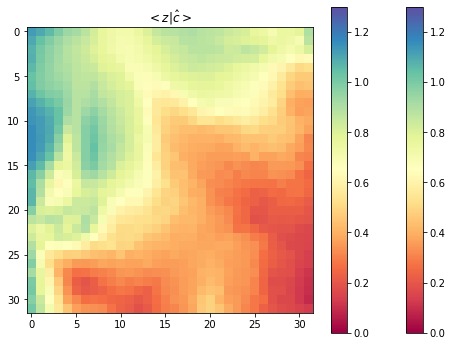

In [42]:
plt.figure(figsize=(8,6))
plt.imshow(((zmean_wide).reshape((32,32))),cmap='Spectral',vmin=0,vmax=1.3,interpolation='none')
plt.colorbar()
plt.title(r'$<z|\hat{c}>$')
plt.savefig('./SOMF_wide_balrog.png', dpi = 250)
# cell_counts
plt.colorbar()

In [43]:
cells_wide_unsheared = cells_wide.copy()

In [46]:
coadd = sompzh5_pass['coadd_object_id'].copy()

In [60]:
sompzh5_pass = sompzh5_pass.rename(columns={"cell_wide_unsheared": "cells_wide_unsheared"})

In [64]:
f = h5py.File('sompz_test.hdf5','r+', track_order=True)

f.create_dataset('catalog/sompz/unsheared/coadd_object_id', data = coadd)
f.create_dataset('catalog/sompz/unsheared/cell_wide', data = cells_wide_unsheared)
f.create_dataset('catalog/sompz/sheared_1m/cell_wide', data = cells_sheared_1m)
f.create_dataset('catalog/sompz/sheared_1p/cell_wide', data = cells_sheared_1p)
f.create_dataset('catalog/sompz/sheared_2m/cell_wide', data = cells_sheared_2m)
f.create_dataset('catalog/sompz/sheared_2p/cell_wide', data = cells_sheared_2p)

<HDF5 dataset "cell_wide": shape (100208944,), type "<i4">

In [65]:
nz=fitsio.read('Y3_y3_redshift_distributions_test_modal_even_Y3_bincond_pileup3.fits')

f.create_dataset('catalog/sompz/pzdata/bin0', data = nz['BIN1'])
f.create_dataset('catalog/sompz/pzdata/bin1', data = nz['BIN2'])
f.create_dataset('catalog/sompz/pzdata/bin2', data = nz['BIN3'])
f.create_dataset('catalog/sompz/pzdata/bin3', data = nz['BIN4'])
f.create_dataset('catalog/sompz/pzdata/zhigh', data = nz['Z_HIGH'])
f.create_dataset('catalog/sompz/pzdata/zlow', data = nz['Z_LOW'])

<HDF5 dataset "zlow": shape (300,), type ">f8">

In [66]:
all_wide_cells = np.arange(wide_som_size)
pz_chat = np.array(histogram(sompzh5_pass,
                             key=key,
                             pcchat = pcchat,
                             cells=all_wide_cells, 
                             cell_weights=np.ones(len(all_wide_cells)), 
                             overlap_weighted_pzc=True,
                             bins=zbins, 
                             individual_chat=True))
np.save(data_dir + 'pzchat.npy', pz_chat)

In [67]:
f.create_dataset('catalog/sompz/pzdata/pz_chat', data = pz_chat)
print(f['catalog/sompz/pzdata/pz_chat'][...].shape)

(1024, 601)


In [68]:
all_deep_cells = np.arange(deep_som_size)
pz_c = np.array(get_deep_histograms(cosmos, key=key, cells=all_deep_cells, 
                                    overlap_weighted_pzc=True, bins=zbins))
np.save(data_dir + 'pzc.npy', pz_c)

In [69]:
f.create_dataset('catalog/sompz/pzdata/pz_c', data = pz_c)
print(f['catalog/sompz/pzdata/pz_c'][...].shape)

(4096, 601)


In [70]:
# convert to DF with cell <-> bin relation
tmp_cells = np.concatenate([tomo_bins_wide[nbin][:,0] for nbin in tomo_bins_wide])
tmp_bins = np.concatenate([(np.ones(len(tomo_bins_wide[nbin][:,0])) * nbin).astype(int) for 
                           nbin in tomo_bins_wide])
tomo_bin_hashtable = pd.Series(tmp_bins, tmp_cells)

#sompzh5 = h5py.File(sompzh5_file, mode='a') # read again with no WL selection applied

In [71]:
nrows = coadd.shape[0]

In [72]:
fluxtypes = ['unsheared', 'sheared_1m', 'sheared_1p', 'sheared_2m', 'sheared_2p']

# add binning info to catalog
for fluxtype in fluxtypes:
    print('add binning {}'.format(fluxtype))
    try:
        #print(f['catalog/sompz/unsheared'].keys())
        f.create_dataset('catalog/sompz/{}/{}'.format(fluxtype, 'bhat'), maxshape=(nrows,),
                shape=(nrows,), dtype='i8')
        print("that worked!")
    except Exception as e:
        print(e)
    tmp = sompzh5_pass['cells_wide_{}'.format(fluxtype)].map(tomo_bin_hashtable)
    tmp[np.isnan(tmp)] = -1
    f['catalog/sompz/{}/bhat'.format(fluxtype)][...] = tmp


add binning unsheared
that worked!
add binning sheared_1m
that worked!
add binning sheared_1p
that worked!
add binning sheared_2m
that worked!
add binning sheared_2p
that worked!


In [62]:
f.close()